# Preparation

### Import

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from google.colab import drive
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model

In [3]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Data inspaction

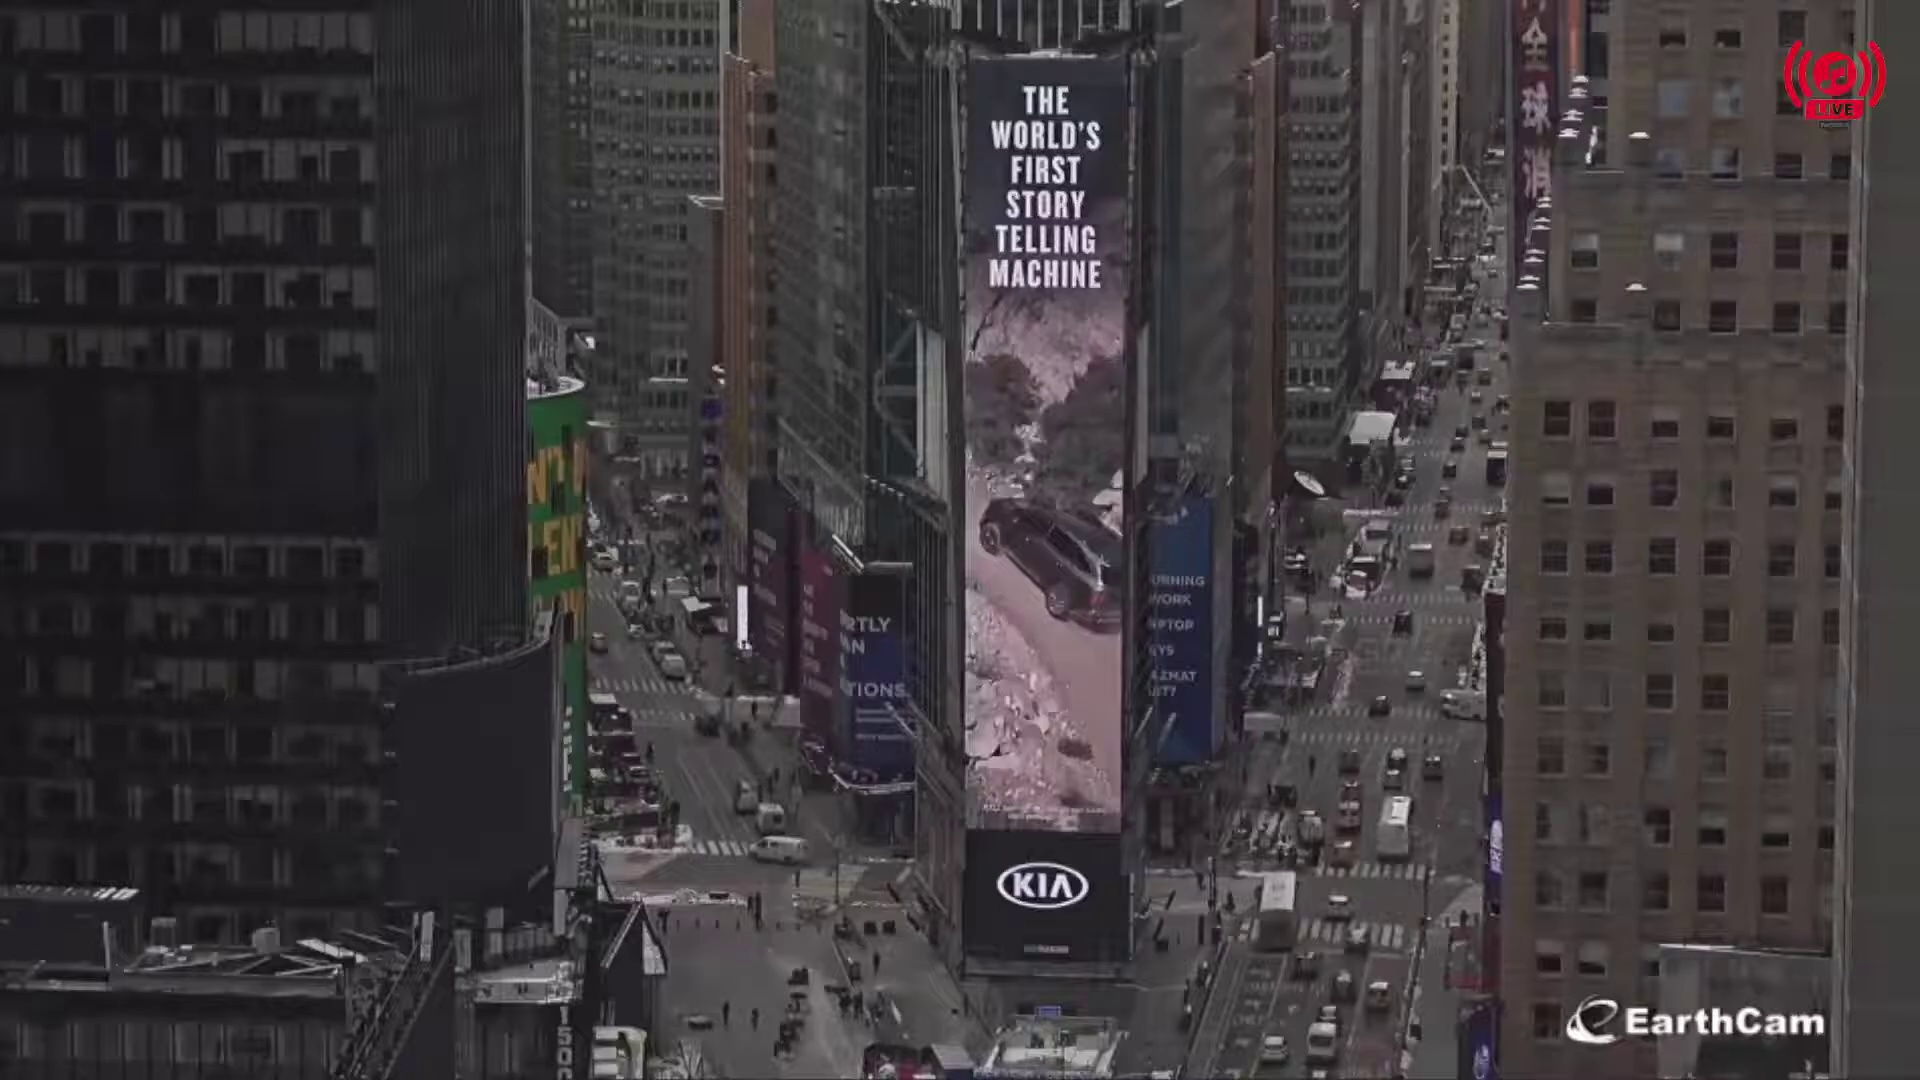

In [4]:
folder = 'drive/MyDrive/Colab Notebooks/StreetCamera'
filename = 'image0.jpg'
path = os.path.join(folder,filename)
img = cv2.imread(path)
cv2_imshow(img)

In [5]:
dataset = []
for image_num in range(500):
  path = folder+"/image{}.jpg".format(image_num)
  img = cv2.imread(os.path.join(folder,filename))
  if img is not None:
    dataset.append(img)

dataset = np.array(dataset)

In [6]:
print('Sample dims: ', dataset.shape)

Sample dims:  (500, 1080, 1920, 3)
